In [16]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [17]:
class MNISTCsvDataset(Dataset):
    def __init__(self, csv_path):
        data = pd.read_csv(csv_path).values
        self.X = data[:, 1:].astype(np.float32) / 255.
        self.y = data[:, 0].astype(np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

train_ds = MNISTCsvDataset('data/mnist_train.csv')
test_ds = MNISTCsvDataset('data/mnist_test.csv')

In [18]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [19]:
random_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

In [20]:
history_losses = np.zeros(len(train_ds))
MOVING_AVG_DECAY = 0.9

def get_smart_batch(loss_history, batch_size, explore_frac=0.5, top_k_frac=0.2):
    n_explore = int(batch_size * explore_frac)
    n_exploit = batch_size - n_explore
    n_total = len(loss_history)

    rand_idxs = np.random.choice(n_total, n_explore, replace=False)

    k = int(top_k_frac * n_total)
    exploit_candidates = np.argsort(-loss_history)[:k]
    if len(exploit_candidates) < n_exploit:
        exploit_idxs = exploit_candidates
    else:
        exploit_idxs = np.random.choice(exploit_candidates, n_exploit, replace=False)

    batch_idxs = np.concatenate([rand_idxs, exploit_idxs])
    np.random.shuffle(batch_idxs)
    return batch_idxs

In [21]:
def train_random(model, train_ds, test_ds, epochs=5, batch_size=64):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()

    train_accuracies, test_accuracies, train_losses = [], [], []
    for epoch in range(epochs):
        correct, n, running_loss = 0, 0, 0
        model.train()
        for x, y in train_loader:
            x, y = x.to('cpu'), y.to('cpu')
            x = x.view(x.size(0), -1)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
            pred_labels = y_pred.argmax(1)
            correct += (pred_labels == y).sum().item()
            n += x.size(0)
        train_accuracies.append(correct / n)
        train_losses.append(running_loss / n)

        test_acc = evaluate(model, test_ds)
        test_accuracies.append(test_acc)
        print(f"Rand-Epoch {epoch+1}: train_acc={train_accuracies[-1]:.4f}, test_acc={test_acc:.4f}")
    return train_accuracies, test_accuracies, train_losses

def train_smart(model, train_ds, test_ds, epochs=5, batch_size=64):
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters())

    per_sample_loss = np.zeros(len(train_ds))
    train_accuracies, test_accuracies, train_losses = [], [], []

    for epoch in range(epochs):
        perm = np.arange(len(train_ds))
        n_batches = len(train_ds) // batch_size
        correct, n, running_loss = 0, 0, 0
        model.train()
        for i in range(n_batches):
            idxs = get_smart_batch(per_sample_loss, batch_size)
            x, y = zip(*[train_ds[j] for j in idxs])
            x = torch.stack(x).view(batch_size, -1).to('cpu')
            y = torch.tensor(y).to('cpu')
            y_pred = model(x)
            losses = loss_fn(y_pred, y)
            loss = losses.mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
            pred_labels = y_pred.argmax(1)
            correct += (pred_labels == y).sum().item()
            n += x.size(0)

            for k, idx in enumerate(idxs):
                per_sample_loss[idx] = MOVING_AVG_DECAY * per_sample_loss[idx] + (1-MOVING_AVG_DECAY) * losses[k].item()

        train_accuracies.append(correct / n)
        train_losses.append(running_loss / n)

        test_acc = evaluate(model, test_ds)
        test_accuracies.append(test_acc)
        print(f"Smart-Epoch {epoch+1}: train_acc={train_accuracies[-1]:.4f}, test_acc={test_acc:.4f}")
    return train_accuracies, test_accuracies, train_losses

def evaluate(model, ds):
    loader = DataLoader(ds, batch_size=256)
    model.eval()
    correct, n = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.view(x.size(0), -1).to('cpu')
            y = y.to('cpu')
            y_pred = model(x)
            pred_labels = y_pred.argmax(1)
            correct += (pred_labels == y).sum().item()
            n += x.size(0)
    return correct / n

Rand-Epoch 1: train_acc=0.9072, test_acc=0.9450
Rand-Epoch 2: train_acc=0.9550, test_acc=0.9603
Rand-Epoch 3: train_acc=0.9683, test_acc=0.9690
Rand-Epoch 4: train_acc=0.9755, test_acc=0.9717
Rand-Epoch 5: train_acc=0.9798, test_acc=0.9703
Smart-Epoch 1: train_acc=0.8996, test_acc=0.9439
Smart-Epoch 2: train_acc=0.9348, test_acc=0.9662
Smart-Epoch 3: train_acc=0.9554, test_acc=0.9726
Smart-Epoch 4: train_acc=0.9711, test_acc=0.9745
Smart-Epoch 5: train_acc=0.9793, test_acc=0.9764


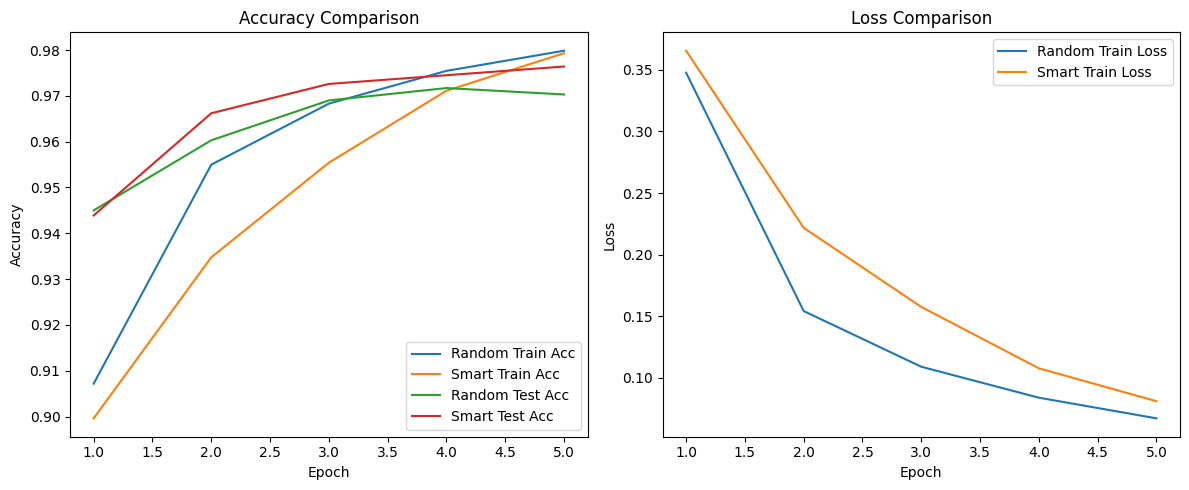

In [22]:
rand_model = SimpleMLP()
rand_train_acc, rand_test_acc, rand_train_loss = train_random(rand_model, train_ds, test_ds)

smart_model = SimpleMLP()
smart_train_acc, smart_test_acc, smart_train_loss = train_smart(smart_model, train_ds, test_ds)

epochs = range(1, len(rand_train_acc)+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, rand_train_acc, label='Random Train Acc')
plt.plot(epochs, smart_train_acc, label='Smart Train Acc')
plt.plot(epochs, rand_test_acc, label='Random Test Acc')
plt.plot(epochs, smart_test_acc, label='Smart Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Comparison')

plt.subplot(1,2,2)
plt.plot(epochs, rand_train_loss, label='Random Train Loss')
plt.plot(epochs, smart_train_loss, label='Smart Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Comparison')

plt.tight_layout()
plt.show()